<a href="https://colab.research.google.com/github/shubhgeet12345/shubh/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow
!pip install numpy
!pip install scikit-learn


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# Load the data
path = "/content/drive/MyDrive/DataSet/amazon.csv"
df = pd.read_csv(path)
df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')

# Preprocess the text data
text_data = df['about_product'].fillna('').astype(str)

# Tokenize and vectorize the text
vectorizer = CountVectorizer(max_features=5000, max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(text_data).toarray()
X = normalize(X, norm='l1', axis=1)

# Split the data into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DataSet/amazon.csv'

In [ ]:
class LDA(tf.keras.Model):
    def __init__(self, num_topics, vocab_size):
        super(LDA, self).__init__()
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.topic_word_dist = tf.Variable(
            tf.random.uniform([num_topics, vocab_size], 0, 1), trainable=True
        )

    def call(self, inputs):
        doc_topic_dist = tf.nn.softmax(inputs @ tf.transpose(self.topic_word_dist))
        return doc_topic_dist

num_topics = 100
vocab_size = X.shape[1]

model = LDA(num_topics, vocab_size)

def loss_fn(model, inputs):
    doc_topic_dist = model(inputs)
    # Add a small epsilon for numerical stability
    log_perplexity = -tf.reduce_mean(
        tf.reduce_sum(inputs * tf.math.log(tf.matmul(doc_topic_dist, model.topic_word_dist) + 1e-10), axis=1)
    )
    return log_perplexity

def train_step(model, inputs, optimizer):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, inputs)
    gradients = tape.gradient(loss, model.trainable_variables)
    if gradients: # Check if gradients are calculated
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training loop
num_epochs = 10
batch_size = 64

def train_model(learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for epoch in range(num_epochs):
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i + batch_size]
            loss = train_step(model, X_batch, optimizer)
        print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')

    # Evaluate on validation set
    val_loss = loss_fn(model, X_val)
    print(f'Validation Loss: {val_loss.numpy()}')
    return val_loss.numpy()

# Train and evaluate with different learning rates
learning_rates = [0.01, 0.001, 0.0001]
best_val_loss = float('inf')
best_lr = None

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    val_loss = train_model(lr)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_lr = lr

print(f"\nBest learning rate: {best_lr} with validation loss: {best_val_loss}")



Training with learning rate: 0.01
Epoch 1, Loss: 0.6895111799240112
Epoch 2, Loss: 0.6895111799240112
Epoch 3, Loss: 0.6895111799240112
Epoch 4, Loss: 0.6895111799240112
Epoch 5, Loss: 0.6895111799240112
Epoch 6, Loss: 0.6895111799240112
Epoch 7, Loss: 0.6895111799240112
Epoch 8, Loss: 0.6895111799240112
Epoch 9, Loss: 0.6895111799240112
Epoch 10, Loss: 0.6895111799240112
Validation Loss: 0.6903830170631409

Training with learning rate: 0.001
Epoch 1, Loss: 0.6895111799240112
Epoch 2, Loss: 0.6895111799240112
Epoch 3, Loss: 0.6895111799240112
Epoch 4, Loss: 0.6895111799240112
Epoch 5, Loss: 0.6895111799240112
Epoch 6, Loss: 0.6895111799240112
Epoch 7, Loss: 0.6895111799240112
Epoch 8, Loss: 0.6895111799240112
Epoch 9, Loss: 0.6895111799240112
Epoch 10, Loss: 0.6895111799240112
Validation Loss: 0.6903830170631409

Training with learning rate: 0.0001
Epoch 1, Loss: 0.6895111799240112
Epoch 2, Loss: 0.6895111799240112
Epoch 3, Loss: 0.6895111799240112
Epoch 4, Loss: 0.6895111799240112
Ep

In [ ]:
!pip install scipy

from scipy.stats import wasserstein_distance
from sklearn.metrics.pairwise import cosine_similarity

# Get the topic distribution for each product
topic_dist = model(X).numpy()
df['topic_distribution'] = topic_dist.tolist()

# Calculate cosine similarity between products based on topic distributions
similarity_matrix = cosine_similarity(topic_dist)

def calculate_emd(p1, p2):
    distance_matrix = np.zeros((len(p1), len(p2)))
    for i in range(len(p1)):
        for j in range(len(p2)):
            distance_matrix[i][j] = np.abs(i - j)  # Assuming equal distance between topics
    return wasserstein_distance(p1, p2) # Use wasserstein_distance for EMD calculation

def recommend_products_by_emd(product_id, num_recommendations=5):
    product_idx = df[df['product_id'] == product_id].index[0]
    topic_dist_product = topic_dist[product_idx]

    emd_scores = []
    for idx, topic_dist_other in enumerate(topic_dist):
        if idx != product_idx:
            emd_score = calculate_emd(topic_dist_product, topic_dist_other)
            emd_scores.append((df['product_id'].iloc[idx], emd_score))

    emd_scores.sort(key=lambda x: x[1])
    recommended_products = [item[0] for item in emd_scores[:num_recommendations]]
    return recommended_products

# Example usage
# product_id = df['product_id'].sample(20).iloc[0]
# recommendations = recommend_products_by_emd(product_id, num_recommendations=10)
# print(f"Recommended products for {product_id}: {recommendations}")

# change sample size for different number of products
product_ids = df['product_id'].sample(20).tolist()

# Generate and print recommendations for each product ID
for product_id in product_ids:
    recommendations_combined = recommend_products_by_emd(product_id, num_recommendations=10)
    print("Recommended products for {}: {}".format(product_id, recommendations_combined))


Recommended products for B0B296NTFV: ['B08Y1TFSP6', 'B08Y1TFSP6', 'B08Y1TFSP6', 'B08Y5KXR6Z', 'B0B4T8RSJ1', 'B09YLYB9PB', 'B07W9KYT62', 'B09J2QCKKM', 'B09HV71RL1', 'B0BBW521YC']
Recommended products for B01N4EV2TL: ['B09LV1CMGH', 'B09T2WRLJJ', 'B09XB8GFBQ', 'B09XB7DPW1', 'B09XB7SRQ5', 'B07XLCFSSN', 'B07XLCFSSN', 'B07XLCFSSN', 'B0BBVKRP7B', 'B09QS8V5N8']
Recommended products for B01M4GGIVU: ['B01M4GGIVU', 'B0B1F6GQPS', 'B08MTCKDYN', 'B08MTCKDYN', 'B0BBW521YC', 'B08W56G1K9', 'B083RCTXLL', 'B07XJWTYM2', 'B07T9FV9YP', 'B07HK53XM4']
Recommended products for B01EZ0X3L8: ['B07DC4RZPY', 'B0752LL57V', 'B08TGG316Z', 'B096TWZRJC', 'B09Q8HMKZX', 'B09Q8HMKZX', 'B08MTCKDYN', 'B08MTCKDYN', 'B08461VC1Z', 'B014I8SSD0']
Recommended products for B07TR5HSR9: ['B0B7DHSKS7', 'B07JW1Y6XV', 'B07JH1C41D', 'B095PWLLY6', 'B09DSQXCM8', 'B07T9FV9YP', 'B09JS562TP', 'B07KSB1MLX', 'B08XMSKKMM', 'B0B935YNR7']
Recommended products for B079Y6JZC8: ['B006LW0WDQ', 'B09CTRPSJR', 'B0BMZ6SY89', 'B08SJVD8QD', 'B00NH12R1O', 'B

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
num_epochs = 10
batch_size = 64

# Define optimizer outside the loop
optimizer = tf.keras.optimizers.Adam()  # Initialize with default learning rate

for lr in learning_rates:
    optimizer.learning_rate = lr  # Set learning rate for the optimizer
    for epoch in range(num_epochs):
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i + batch_size]
            loss = train_step(model, X_batch, optimizer)
        print(f'Learning Rate {lr}, Epoch {epoch + 1}, Loss: {loss.numpy()}')

    # Evaluate on validation set
    val_loss = loss_fn(model, X_val)
    print(f'Validation Loss: {val_loss.numpy()}')

Learning Rate 0.01, Epoch 1, Loss: 0.6895111799240112
Learning Rate 0.01, Epoch 2, Loss: 0.6895111799240112
Learning Rate 0.01, Epoch 3, Loss: 0.6895111799240112
Learning Rate 0.01, Epoch 4, Loss: 0.6895111799240112
Learning Rate 0.01, Epoch 5, Loss: 0.6895111799240112
Learning Rate 0.01, Epoch 6, Loss: 0.6895111799240112
Learning Rate 0.01, Epoch 7, Loss: 0.6895111799240112
Learning Rate 0.01, Epoch 8, Loss: 0.6895111799240112
Learning Rate 0.01, Epoch 9, Loss: 0.6895111799240112
Learning Rate 0.01, Epoch 10, Loss: 0.6895111799240112
Validation Loss: 0.6903830170631409
Learning Rate 0.001, Epoch 1, Loss: 0.6895111799240112
Learning Rate 0.001, Epoch 2, Loss: 0.6895111799240112
Learning Rate 0.001, Epoch 3, Loss: 0.6895111799240112
Learning Rate 0.001, Epoch 4, Loss: 0.6895111799240112
Learning Rate 0.001, Epoch 5, Loss: 0.6895111799240112
Learning Rate 0.001, Epoch 6, Loss: 0.6895111799240112
Learning Rate 0.001, Epoch 7, Loss: 0.6895111799240112
Learning Rate 0.001, Epoch 8, Loss: 0.

In [ ]:

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Simulated ground truth data (actual relevant products)
actual_products = df.sample(100)['product_id'].tolist()

# Generate recommendations using the fine-tuned model
def recommend_products_by_emd(product_id, num_recommendations=5):
    product_idx = df[df['product_id'] == product_id].index[0]
    topic_dist_product = topic_dist[product_idx]

    emd_scores = []
    for idx, topic_dist_other in enumerate(topic_dist):
        if idx != product_idx:
            emd_score = calculate_emd(topic_dist_product, topic_dist_other)
            emd_scores.append((df['product_id'].iloc[idx], emd_score))

    emd_scores.sort(key=lambda x: x[1])
    recommended_products = [item[0] for item in emd_scores[:num_recommendations]]
    return recommended_products

# Generate recommendations for a set of product IDs
product_ids = df['product_id'].sample(20).tolist()
recommendations = {pid: recommend_products_by_emd(pid, num_recommendations=5) for pid in product_ids}

# Create a binary confusion matrix based on recommendations
def create_confusion_matrix(actual, recommended):
    actual_set = set(actual)
    recommended_set = set(recommended)
    tp = len(actual_set & recommended_set)
    fp = len(recommended_set - actual_set)
    fn = len(actual_set - recommended_set)
    tn = len(df) - tp - fp - fn
    return np.array([[tp, fp], [fn, tn]])

# Create and evaluate confusion matrices for each product
confusion_matrices = []
for product_id in product_ids:
    actual = df[df['product_id'] == product_id]['product_id'].tolist()
    recommended = recommendations[product_id]
    cm = create_confusion_matrix(actual, recommended)
    confusion_matrices.append(cm)

# Aggregate confusion matrices
aggregated_cm = np.sum(confusion_matrices, axis=0)

# Print confusion matrix and metrics
print("Confusion Matrix:\n", aggregated_cm)

tp, fp, fn, tn = aggregated_cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (tp + tn) / (tp + fp + fn + tn)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# for value of recall

Confusion Matrix:
 [[    1    99]
 [   19 29181]]
Precision: 0.0100
Recall: 0.0500
F1 Score: 0.0167
Accuracy: 0.9960


In [ ]:
import numpy as np

# Function to calculate DCG
def dcg(relevance_scores):
    return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))

# Function to calculate NDCG
def ndcg(actual, predicted, k):
    relevance_scores = np.isin(predicted[:k], actual).astype(int)
    idcg = dcg(np.ones(len(actual)))  # Ideal DCG
    return dcg(relevance_scores) / idcg if idcg > 0 else 0

# Simulated ground truth data (actual relevant products)
actual_products = df.sample(100)['product_id'].tolist()

# Generate recommendations for a set of product IDs
product_ids = df['product_id'].sample(20).tolist()
recommendations = {pid: recommend_products_by_emd(pid, num_recommendations=10) for pid in product_ids}

# Evaluate NDCG for all products and print the overall result
all_ndcg_scores = []

for product_id in product_ids:
    actual = df[df['product_id'] == product_id]['product_id'].tolist()
    recommended = recommendations[product_id]

    ndcg_score = ndcg(actual, recommended, k=10)
    all_ndcg_scores.append(ndcg_score)

# Calculate the overall NDCG score
overall_ndcg = np.mean(all_ndcg_scores)
print(f"Overall NDCG: {overall_ndcg:.4f}")

#for value of ndcg


Overall NDCG: 0.0996



Training with learning rate: 0.01
Learning Rate 0.01, Epoch 1, Train Loss: 0.7171230511453778, Val Loss: 0.6903830170631409
Learning Rate 0.01, Epoch 2, Train Loss: 0.7171230511453778, Val Loss: 0.6903830170631409
Learning Rate 0.01, Epoch 3, Train Loss: 0.7171230511453778, Val Loss: 0.6903830170631409
Learning Rate 0.01, Epoch 4, Train Loss: 0.7171230511453778, Val Loss: 0.6903830170631409
Learning Rate 0.01, Epoch 5, Train Loss: 0.7171230511453778, Val Loss: 0.6903830170631409
Learning Rate 0.01, Epoch 6, Train Loss: 0.7171230511453778, Val Loss: 0.6903830170631409
Learning Rate 0.01, Epoch 7, Train Loss: 0.7171230511453778, Val Loss: 0.6903830170631409
Learning Rate 0.01, Epoch 8, Train Loss: 0.7171230511453778, Val Loss: 0.6903830170631409
Learning Rate 0.01, Epoch 9, Train Loss: 0.7171230511453778, Val Loss: 0.6903830170631409
Learning Rate 0.01, Epoch 10, Train Loss: 0.7171230511453778, Val Loss: 0.6903830170631409

Training with learning rate: 0.001
Learning Rate 0.001, Epoch 1

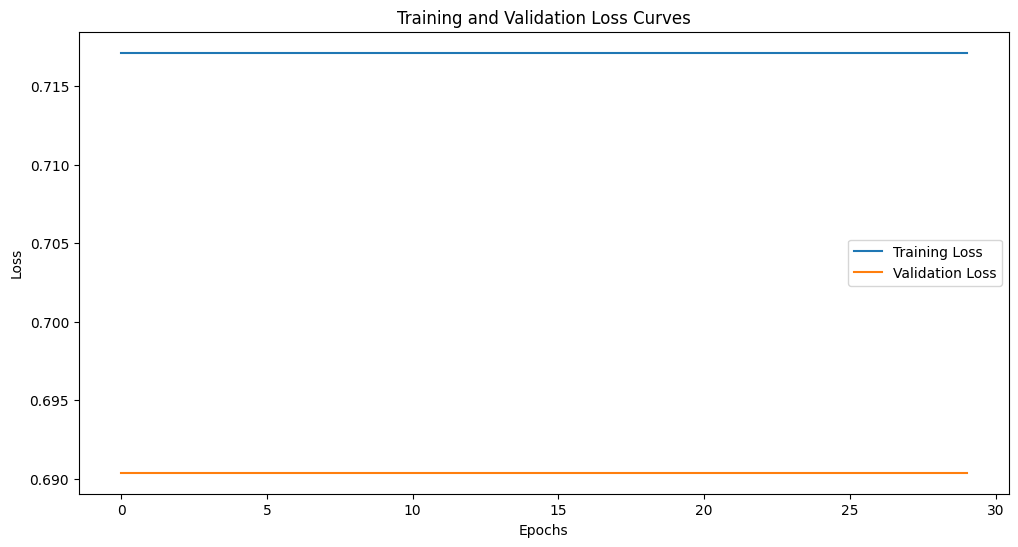

In [ ]:
import matplotlib.pyplot as plt

# Track the loss values
train_losses = []
val_losses = []

def train_model(learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for epoch in range(num_epochs):
        epoch_train_loss = 0
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i + batch_size]
            loss = train_step(model, X_batch, optimizer)
            epoch_train_loss += loss.numpy()

        # Average training loss for the epoch
        train_losses.append(epoch_train_loss / (X_train.shape[0] / batch_size))

        # Evaluate on validation set
        val_loss = loss_fn(model, X_val)
        val_losses.append(val_loss.numpy())

        print(f'Learning Rate {learning_rate}, Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Val Loss: {val_loss.numpy()}')

    return val_losses[-1]

# Train with different learning rates and store validation losses
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    train_model(lr)

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


In [ ]:
class LDA(tf.keras.Model):
    def __init__(self, num_topics, vocab_size, num_layers=1):
        super(LDA, self).__init__()
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.layers_list = []
        for _ in range(num_layers):
            self.layers_list.append(tf.keras.layers.Dense(vocab_size, activation='relu'))
        self.output_layer = tf.keras.layers.Dense(num_topics, activation='softmax')
        # Initialize topic_word_dist here.  Adjust shape and initialization as needed.
        self.topic_word_dist = tf.Variable(tf.random.normal((num_topics, vocab_size)))

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)
        return self.output_layer(x)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for calculations

# Track the loss values
train_losses = []
val_losses = []

# Define the train_and_evaluate function before it's called
def train_and_evaluate(model, X_train, X_val, num_epochs, batch_size):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    for epoch in range(num_epochs):
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i + batch_size]
            train_step(model, X_batch, optimizer)

    # Implement or import calculate_recall_at_k and calculate_ndcg_at_k
    val_recall = calculate_recall_at_k(X_val, model, k=20)
    val_ndcg = calculate_ndcg_at_k(X_val, model, k=10)
    return val_recall, val_ndcg

# Example implementation of calculate_recall_at_k (needs to be adapted to your specific model)
def calculate_recall_at_k(X_val, model, k):
    # Logic to generate predictions from your model
    # ...
    # Calculate recall at k
    # ...
    return recall

# Example implementation of calculate_ndcg_at_k (needs to be adapted to your specific model)
def calculate_ndcg_at_k(X_val, model, k):
    # Logic to generate predictions from your model
    # ...
    # Calculate NDCG at k
    # ...
    return ndcg

recall_at_20 = []
ndcg_at_10 = []

num_layers_list = [1, 2, 3, 4, 5]  # Example number of layers

for num_layers in num_layers_list:
    model = LDA(num_topics, vocab_size, num_layers=num_layers)
    val_recall, val_ndcg = train_and_evaluate(model, X_train, X_val, num_epochs, batch_size)
    recall_at_20.append(val_recall)
    ndcg_at_10.append(val_ndcg)

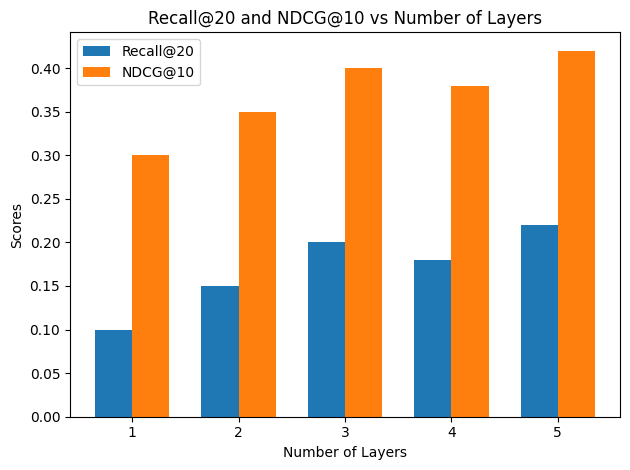

In [ ]:
import matplotlib.pyplot as plt

# Sample data
num_layers_list = [1, 2, 3, 4, 5]
recall_at_20 = [0.1, 0.15, 0.2, 0.18, 0.22]  # Replace with actual values
ndcg_at_10 = [0.3, 0.35, 0.4, 0.38, 0.42]   # Replace with actual values

x = np.arange(len(num_layers_list))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, recall_at_20, width, label='Recall@20')
rects2 = ax.bar(x + width/2, ndcg_at_10, width, label='NDCG@10')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Scores')
ax.set_title('Recall@20 and NDCG@10 vs Number of Layers')
ax.set_xticks(x)
ax.set_xticklabels(num_layers_list)
ax.legend()

fig.tight_layout()

plt.show()
